# Tutorial 1. TUFLOW FV Post-Processing Using Xarray

This notebook provides a high-level view on the typical usage of the TfvDomain xarray accessor tool. 

This notebook is used in combination with the [TUFLOW FV Python Toolbox](https://tfv.readthedocs.io/en/latest/index.html) (tfv) package. 
To follow along on your own computer, please download the demonstration notebooks from the [TUFLOW Downloads Page](https://www.tuflow.com/downloads/#utilities). Look for the TUFLOW FV Python Toolbox download.
Installation instructions are provided on our [TUFLOW FV Python Toolbox Wiki Page](https://fvwiki.tuflow.com/TUFLOW_FV_Python_Toolbox).


In [1]:
import xarray as xr  # We utilise xarray to do all the heavy lifting 
import tfv.xarray
from pathlib import Path # We'll also make use of the `pathlib` module to assist with managing file-paths, although this is entirely optional! 

## Loading Data
We treat TUFLOW FV NetCDF files like any ordinary xarray dataset.

Older copies of TUFLOW FV do not have a cf-compliant datetime, so you need to add in the kwarg argument `decode_times=False` so that xarray doesn't try to convert the time array into a datetime array. 

The standard xarray print output for a TUFLOW FV isn't very easy or useful because of the large number of variables and coordinates. Also, native xarray isn't able to help us process these files in any standard manner because they are unstructured.

In [2]:
model_folder = Path(r'..\data')
model_file = 'HYD_002_extended.nc'

ds = xr.open_dataset(model_folder / model_file, decode_times=False)
ds

<xarray.Dataset>
Dimensions:              (Time: 145, NumCells2D: 1375, MaxNumCellVert: 4,
                          NumCells3D: 6453, NumVert2D: 1419,
                          NumLayerFaces3D: 7828, Sum2DVertCells: 5285)
Dimensions without coordinates: Time, NumCells2D, MaxNumCellVert, NumCells3D,
                                NumVert2D, NumLayerFaces3D, Sum2DVertCells
Data variables: (12/26)
    ResTime              (Time) float64 ...
    cell_Nvert           (NumCells2D) int32 ...
    cell_node            (NumCells2D, MaxNumCellVert) int32 ...
    NL                   (NumCells2D) int32 ...
    idx2                 (NumCells3D) int32 ...
    idx3                 (NumCells2D) int32 ...
    ...                   ...
    TEMP                 (Time, NumCells3D) float32 ...
    SAL                  (Time, NumCells3D) float32 ...
    RHOW                 (Time, NumCells3D) float32 ...
    node_NVC2            (NumVert2D) int32 ...
    node_cell2d_idx      (Sum2DVertCells) int32 ...
    node_cell2d_weights  (Sum2DVertCells) float64 ...
Attributes:
    Origin:     Created by TUFLOWFV
    Type:       Cell-centred TUFLOWFV output
    spherical:  true
    Dry depth:  0.01

This is where the `tfv.xarray` module is used to enhance the functionality of native xarray by allowing us to work with unstructured files (currently only supporting TUFLOW FV outputs).

There are two ways to enable the extension. 
1. Calling the appropriate accessor method on the dataset, e.g., `fv = tfv.xarray.TfvDomain(ds)` \
   (we are using a TUFLOW FV domain file, or in other words, a 2D / 3D spatial NetCDF).
2. Simply calling `fv = ds.tfv` which will attempt to auto-detect what you have. 

In [3]:
# These are equivalent - use whichever you prefer.
fv = ds.tfv
# fv = tfv.xarray.TfvDomain(ds)
fv   # Show the contents of fv

<xarray.Dataset>
Dimensions:      (Time: 145, NumLayerFaces3D: 7828, NumCells2D: 1375,
                  NumCells3D: 6453)
Coordinates:
  * Time         (Time) datetime64[ns] 2011-02-01 ... 2011-02-07T00:00:11.899...
Dimensions without coordinates: NumLayerFaces3D, NumCells2D, NumCells3D
Data variables:
    ResTime      (Time) float64 1.848e+05 1.848e+05 ... 1.85e+05 1.85e+05
    layerface_Z  (Time, NumLayerFaces3D) float32 ...
    stat         (Time, NumCells2D) int32 ...
    H            (Time, NumCells2D) float32 ...
    V_x          (Time, NumCells3D) float32 ...
    V_y          (Time, NumCells3D) float32 ...
    D            (Time, NumCells2D) float32 ...
    ZB           (Time, NumCells2D) float32 ...
    TEMP         (Time, NumCells3D) float32 ...
    SAL          (Time, NumCells3D) float32 ...
    RHOW         (Time, NumCells3D) float32 ...
Attributes:
    Origin:     Created by TUFLOWFV
    Type:       Cell-centred TUFLOWFV output
    spherical:  true
    Dry depth:  0.01

TUFLOW FV domain xarray accessor object

As you can see, the print output is now shorter and only shows the "useful" variables, i.e. the ones that we are typically wanting to plot. All the original data is still there, but has just been hidden in this print view. 
You can also see that the `Time` coordinate is based on a properly formatted datetime array. 

Conceptually - this `TfvDomain` object has just added on a number of useful methods to help you work with the TUFLOW FV unstructured data.

All the hard work is being done behind the scenes by the existing tools available in `FvExtractor`, or the plotting functions in `Visual`.

## Some Common Use Examples

### Spatial Plots

By default the first variable will be plotted on the first timestep.

For many model results this will be surface elevation at the first timestep.

In [4]:
fv.plot()

For further control there are a wide range of arguments to style plots to your liking. 
For velocity outputs, i.e. if you have `V_x` and `V_y` in your dataset, you can request `V` or `VDir` directly and the fv.plot functionality will take care of the processing. 

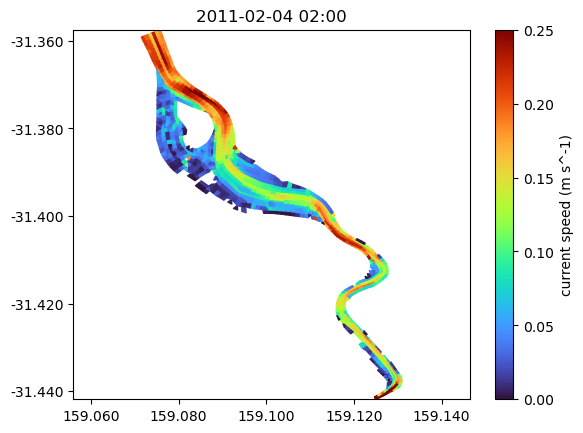

In [5]:
fv.plot('V', '2011-02-04 02:00', cmap='turbo', clim=(0, 0.25), datum='depth')

# Other things to try:
# Depth-averaging, e.g., datum=["sigma", "height", "depth"], combined with limits
# Shading = ["interp", "patch", "contour"]

# Time can be provided as a str, a Timestamp object, or a simple integer.

In addition to the simple plots above, all the plotting methods can be embedded in normal matplotlib figures so you have control over how you display your results. 

Here is an example that provides some building blocks you might use. It plots velocity, salinity and temperature in the surface 1m on a figure with subplots at 2am on the 5th of February, 2011.

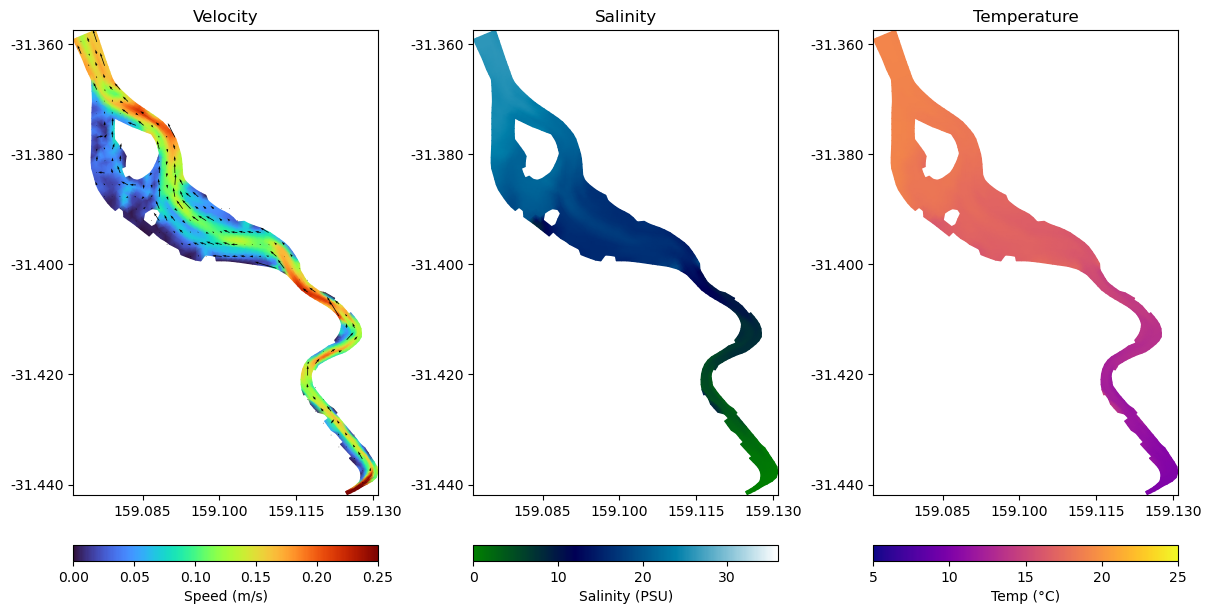

In [6]:
import matplotlib.pyplot as plt

# With datum='depth', this is the surface 1m. 
# Experiment with datum='height' to see how the results change. 
datum = 'depth'
limits = (0,1)

fig, axes = plt.subplots(ncols=3, figsize=(12, 6), constrained_layout=True)

ts = '2011-02-05 02:00'

ax = axes[0]
p1 = fv.plot('V', ts, ax=ax,  shading='interp', cmap='turbo', clim=(0, 0.25), datum=datum, limits=limits, colorbar=False)  # By setting datum to depth, this is now the "surface 1m")
v1 = fv.plot_vector('V', ts, ax=ax, color='k')   # We can plot a vector overlay using the `plot_vector` method here
ax.set_title('Velocity')
plt.colorbar(p1.patch, ax=ax, orientation='horizontal', label='Speed (m/s)')

ax = axes[1]
p2 = fv.plot('SAL', ts, ax=ax,  shading='interp', cmap='ocean', clim=(0, 36), datum=datum, limits=limits, colorbar=False)
ax.set_title('Salinity')
plt.colorbar(p2.patch, ax=ax, orientation='horizontal', label='Salinity (PSU)')

ax = axes[2]
p3 = fv.plot('TEMP', ts, ax=ax, shading='interp', cmap='plasma', clim=(5, 25), datum=datum, limits=limits, colorbar=False)
ax.set_title('Temperature')
plt.colorbar(p3.patch, ax=ax, orientation='horizontal', label='Temp (°C)')

plt.show()

### Interactive Plotting

The `tfv` tools work great in interactive Python, such as with JupyterLab.

Often we just want to interactively look at our model results to ensure that everything is working well, or to understand the results. We can use the `plot_interactive` method to enable animated plotting so we can review our results.

In general, the arguments to the `plot_interactive` method are the same as the `plot` method. We can also add on vectors, and set up multiple plots. This is covered in another tutorial.

We first need to turn on interactive plotting by enabling matplotlib in widget model - run this once `%matplotlib widget`. You may need to install `ipympl` if this fails.

In [7]:
%matplotlib widget

*Output hidden because it doesn't render nicely in on tutorial page*

In [ ]:
fv.plot_interactive('V', cmap='turbo', clim=(0,0.5), datum='depth', vectors=True)
plt.show()

To turn off interactive plotting (which can often make your sessions run faster, a good idea when you don't need it), use `%matplotlib inline`

In [9]:
plt.close('all')
%matplotlib inline

### Extracting and Plotting Timeseries

To extract a timeseries from the model domain result we can provide either a simple tuple with (X,Y), or a dictionary with named locations. 

For example, we may wish to extract two timeseries at "P1" and "P2", which we then want to plot and convert to a `pandas` dataframe.
By default, calls to the fv object will be returned with xarray objects, but these are easily converted by calling the `.to_dataframe()` method.

In [10]:
locs = {
    'P1': (159.1, -31.39), 
    'P2': (159.115, -31.395), 
}

ts = fv.get_timeseries(['H', 'V', 'TEMP'], locs)
ts_df = ts.to_dataframe()

# Output hidden because progress bars don't render nicely here! 

Extracting timeseries, please wait: 100%|████████████████████████████████████████████| 145/145 [00:01<00:00, 92.25it/s]


In [11]:
ts

<xarray.Dataset>
Dimensions:   (Time: 145, Location: 2)
Coordinates:
  * Time      (Time) datetime64[ns] 2011-02-01 ... 2011-02-07T00:00:11.899897210
  * Location  (Location) <U2 'P1' 'P2'
    x         (Location) float64 159.1 159.1
    y         (Location) float64 -31.39 -31.39
    z         (Location) float32 -1.068 -4.886
Data variables:
    H         (Time, Location) float64 -0.001545 -0.0008779 ... 0.06717 0.07611
    V         (Time, Location) float64 0.0 0.0 0.05311 ... 0.01978 0.004996
    TEMP      (Time, Location) float64 20.0 20.0 19.96 ... 17.36 16.61 17.34
Attributes:
    Origin:     Timeseries extracted from TUFLOWFV cell-centered output using...
    Type:       Timeseries cell from TUFLOWFV Output
    spherical:  true
    Dry depth:  0.01
    Datum:      sigma
    Limits:     (0, 1)
    Agg Fn:     mean

In [12]:
ts_df.head()

x       y         z         H  \
Time                          Location                                        
2011-02-01 00:00:00.000000000 P1        159.100 -31.390 -1.067781 -0.001545   
                              P2        159.115 -31.395 -4.886311 -0.000878   
2011-02-01 01:00:17.809976613 P1        159.100 -31.390 -1.067781  0.049078   
                              P2        159.115 -31.395 -4.886311  0.108249   
2011-02-01 02:00:00.263493507 P1        159.100 -31.390 -1.067781 -0.091997   

                                               V       TEMP  
Time                          Location                       
2011-02-01 00:00:00.000000000 P1        0.000000  20.000000  
                              P2        0.000000  20.000001  
2011-02-01 01:00:17.809976613 P1        0.053110  19.960014  
                              P2        0.037206  19.989328  
2011-02-01 02:00:00.263493507 P1        0.003442  19.927108

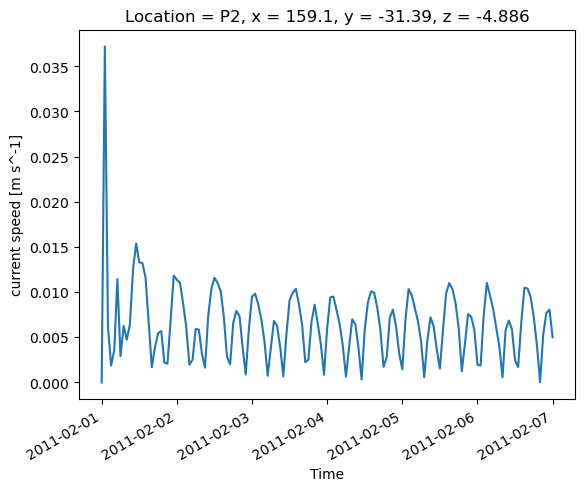

In [13]:
ts['V'][:, 1].plot()

### Sheet Timeseries

We typically want to review results that vary in time and space using plan view plots, named sheet plots in TUFLOW FV nomclementure. 2D model results can be readily displayed in plan view. However, for 3D results we need to reduce 3D results to 2D using some dimension reduction logic. Most often we just depth-average, which is the default throughout `tfv`. 

The `get_sheet` method will handle extracting 2D or 3D (to 2D) results, and will take care of the dimension reduction as needed. 
You can supply the following arguments to control how the dimension reduction for 3D variables is handled:
1. `datum`: One of `sigma, depth, height, elevation`.
2. `limits`: A tuple containing limits, for example (0, 1) or (5, 10). 
3. `agg`: One of `mean, min, max`. This is the general aggregation method to apply to the selected vertical range. \
By default, this will be `mean` (i.e., take the vertically weighted mean over the depth range based on `datum` and `limits`). Using `max` will return the maximum value in our selected depth range, and so on with `min`.

For more info, see [the TUFLOW FV wiki page](https://fvwiki.tuflow.com/index.php?title=Depth_Averaging_Results)

In [14]:
# This extracts ALL timesteps between the 2nd to 4th of Feb 2011, and takes the average of the top 2m
sht = fv.get_sheet('SAL', slice('2011-02-02', '2011-02-04'), datum='depth', limits=(0,2))
sht

<xarray.Dataset>
Dimensions:      (Time: 72, NumLayerFaces3D: 7828, NumCells2D: 1375)
Coordinates:
  * Time         (Time) datetime64[ns] 2011-02-02T00:00:49.390212934 ... 2011...
Dimensions without coordinates: NumLayerFaces3D, NumCells2D
Data variables:
    ResTime      (Time) float64 1.848e+05 1.848e+05 ... 1.849e+05 1.849e+05
    layerface_Z  (Time, NumLayerFaces3D) float32 ...
    stat         (Time, NumCells2D) int32 ...
    SAL          (Time, NumCells2D) float64 0.0 0.0 0.0 0.0 ... 28.63 28.83 28.7
Attributes:
    Origin:     Created by TUFLOWFV
    Type:       Cell-centred TUFLOWFV output
    spherical:  true
    Dry depth:  0.01

TUFLOW FV domain xarray accessor object

The result 'sht' returned is another `TfvDomain` object - we can plot these 2D results using the `.plot` method we saw above, or we can now use them for our own custom analysis.

### Built-In Statistics

The `tfv` tools can handle basic statistics. The `get_statistics` method first calls the `get_sheet` method and then runs statistics on the `TfvDomain` object.

In [15]:
# List of percentiles to grab, as well as some common stats
stats = ['p5', 'p50', 'p97.5', 'p99', 'min', 'mean', 'max']

# Do stats on velocity for the bottom 1m (default of limits is (0, 1), and with datum='height', we get the bottom 1m). 
stat = fv.get_statistics(stats, 'V', datum='height')
stat

<xarray.Dataset>
Dimensions:      (Time: 1, NumLayerFaces3D: 7828, NumCells2D: 1375)
Coordinates:
  * Time         (Time) datetime64[ns] 2011-02-01
Dimensions without coordinates: NumLayerFaces3D, NumCells2D
Data variables:
    ResTime      (Time) float64 1.848e+05
    layerface_Z  (Time, NumLayerFaces3D) float32 ...
    stat         (Time, NumCells2D) int32 ...
    V_min        (Time, NumCells2D) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    V_mean       (Time, NumCells2D) float64 0.06768 0.07583 ... 0.09753 0.06104
    V_max        (Time, NumCells2D) float64 0.1095 0.1341 0.197 ... 0.2036 0.157
    V_p5         (Time, NumCells2D) float64 0.02041 0.02543 ... 0.05243 0.02886
    V_p50        (Time, NumCells2D) float64 0.07269 0.08254 ... 0.09321 0.05949
    V_p97.5      (Time, NumCells2D) float64 0.1024 0.1114 ... 0.1457 0.101
    V_p99        (Time, NumCells2D) float64 0.1029 0.1128 ... 0.1702 0.1377
Attributes:
    Origin:     Created by TUFLOWFV
    Type:       Cell-centred TUFLOWFV output
    spherical:  true
    Dry depth:  0.01

TUFLOW FV domain xarray accessor object

Text(0.5, 1.0, 'Our 99th Percentile Velocity Result')

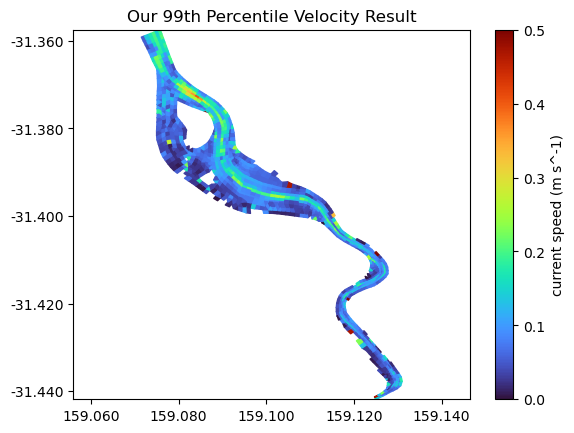

In [16]:
stat.plot('V_p99', cmap='turbo', clim=(0,0.5))
plt.title('Our 99th Percentile Velocity Result')

### Exporting New Results

You can use xarray to export results back to NetCDF. This is a great feature and allows you to save custom output variables into a TUFLOW FV unstructured mesh format for display in other software such as the TUFLOW Viewer Plugin for QGIS. 

Common examples might be to process large TUFLOW FV result here in Python, do some post-processing (e.g., some statistics?), or slice it to a smaller time period, and then use the `to_netcdf` method to export it back. Results exported in this manner will be formatted as any normal TUFLOW FV result.

As an example, we can trim our result into something much smaller, like this:

In [17]:
fv_small = fv.isel(Time=slice(10, 20))  # Here we've used an `Xarray` native function - isel. This selected the 10th through to 19th timestep. 
fv_small.to_netcdf('my_smaller_netcdf.nc')
# fv_small

This concludes the basic usage tutorial.